# Problem Set 4
### by Daniel Tracht, February 2019

## Problem 1
For this problem, we use the 200 data points provided in the incomes.txt file, containing incomes reported in U.S. dollars.  We will be using the log normal distribtion

### Part a
We wish to plot a histogram of the percentages from our data with 30 bins:

In [1]:
# Import the necessary libraries
import numpy as np
import scipy.stats as sts
import requests

# Download and save the data file incomes.txt
url = ('https://raw.githubusercontent.com/dtracht/persp-model-econ_W19/' +
       'master/ProblemSets/PS4/data/incomes.txt')
data_file = requests.get(url, allow_redirects=True)
open('data/incomes.txt', 'wb').write(data_file.content)

# Load the data as a NumPy array
pts = np.loadtxt('data/incomes.txt')


(0, 140000)

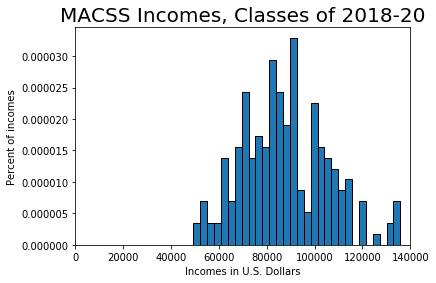

In [3]:
import matplotlib.pyplot as plt

num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])

### Part b
We wish to plot the probability density function of the lognormal distribution, $$ f\left(x | \mu = 11.0, \sigma = 0.5  \right) $$ for $$ 0 \leq x \leq 150000 $$:

In [4]:
# takes vector of x values, parameters for mu and sigma
# returns vector of pdf values for the lognormal
from scipy.stats import lognorm
def lognormal_pdf (xvals, mu, sigma):
    pdf_vals = (1 / (xvals * sigma * np.sqrt(2 * np.pi))) * np.exp (-(np.log(xvals)-mu)**2 / (2 * sigma**2))
    #pdf_vals = lognorm.pdf(xvals, sigma, loc=mu, scale=np.exp(mu))
    #take pdf values that are rounded to zero and reset them to very low
    pdf_zero = pdf_vals==0
    pdf_vals[pdf_zero] = 1e-16
    return pdf_vals

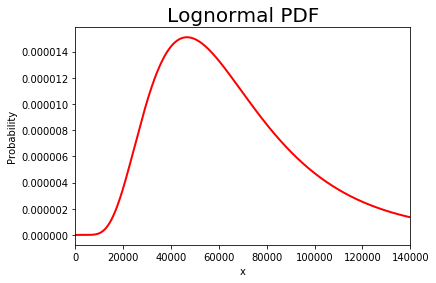

In [5]:
# cannot actually start at zero
dist_pts = np.linspace(1e-16, 150000, 1000)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_1, sig_1),
         linewidth=2, color='r', label='1: $\mu$=11.0,$\sigma$=0.5')
plt.title("Lognormal PDF", fontsize=20)
plt.xlabel("x")
plt.ylabel("Probability")
plt.xlim([0,140000])
plt.show()

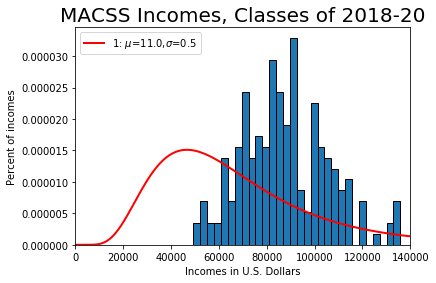

In [6]:
# Plot histogram with the PDF overlaid
num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])

plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_1, sig_1),
         linewidth=2, color='r', label='1: $\mu$=11.0,$\sigma$=0.5')
plt.legend(loc='upper left')
plt.show()

We wish to find the log likelihood value for this particular parameteriziation of this function form and the given data:

In [7]:
# function that takes a vector of x values, and parameters mu and sigma
# returns the log likelihood for that vector for the lognormal distribution
def log_likelihood(xvals, mu, sigma):
    pdf_vals = lognormal_pdf(xvals, mu, sigma)
    log_pdf_vals = np.log(pdf_vals)
    log_likelihood = log_pdf_vals.sum()
    return log_likelihood

In [8]:
print('Log-likelihood:', log_likelihood(pts, mu_1, sig_1))

Log-likelihood: -2385.856997808558


### Part c
We wish to estimate the parameters for a log normal distribution to fit this data by the method of maxmimum likelihood estimation:

In [9]:
# a critereon function to be passed to the minimizer
def crit(params, *args):
    mu, sigma = params
    xvals, junk = args
    log_likelihood_value = log_likelihood(xvals, mu, sigma)
    neg_log_likelihood_value = -log_likelihood_value
    
    return neg_log_likelihood_value

In [10]:
import scipy.optimize as opt

# starting from our values in part b
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
mle_args = (pts, 0)
# constraining sigma to be positive
bnds = ((None, None), (1e-16, None))
results = opt.minimize(crit, params_init, args=(mle_args), method='SLSQP', bounds=bnds)
mu_MLE, sig_MLE = results.x

We wish to plot our new distribution as well as our original guess and the data:

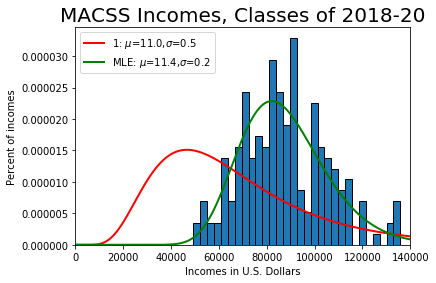

In [11]:
# Plot histogram with the old PDF and new PDF overlaid
num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])

plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_1, sig_1),
         linewidth=2, color='r', label='1: $\mu$=11.0,$\sigma$=0.5')
plt.legend(loc='upper left')

plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_MLE, sig_MLE),
         linewidth=2, color='g', label='MLE: $\mu$=11.4,$\sigma$=0.2')
plt.legend(loc='upper left')

plt.show()

We wish to get the variance-covariance matrix for out estimates.  However, using the contstrained method above, the optimizer does not return an inverse Hessian object.  To get it, we can simply use a method that returns one beginning at the solution to the contstrained problem.

In [12]:
# starting from our values in the constrained case
mu_init = mu_MLE
sig_init = sig_MLE
params_init = np.array([mu_init, sig_init])
mle_args = (pts, 0)

results = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE_2, sig_MLE_2 = results.x

print('mu_MLE=', mu_MLE_2, ' sig_MLE=', sig_MLE_2)
print('MLE Log-likelihood:', log_likelihood(pts, mu_MLE_2, sig_MLE_2))

vcv_mle = results.hess_inv

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

mu_MLE= 11.359022994120751  sig_MLE= 0.20817731910735596
MLE Log-likelihood: -2241.7193013573587
VCV(MLE) =  [[1.94308215e-04 1.27192004e-05]
 [1.27192004e-05 1.24567598e-04]]
Standard error for mu estimate =  0.013939448157069998
Standard error for sigma estimate =  0.01116098553849848


### Part d
We wish to preform a likelihood ratio test to determine the probability that the data came from the distribution using the parameters from part b:

In [13]:
# null hypothesis coming from the parameters in part b
mu_new, sig_new = np.array([11, 0.5])
log_lik_h0 = log_likelihood(pts, mu_new, sig_new)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_likelihood(pts, mu_MLE, sig_MLE)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2385.856997808558
MLE log likelihood -2241.7193013574033
likelihood ratio value 288.27539290230925
chi squared of H0 with 2 degrees of freedom p-value =  0.0


The probability of the data being observed under the assumption of the functional form and parameters in part b is so small it rounds to zero in floating point operation.

### Part e
We wish to estimate the probability that a graduate of MACSS will earn more than 100,000 dollars and the probability that a graduate of MACSS will ear less than 75,000 dollars using the model and parameters we have estimated.  For this we can go to the CDF of the log normal distribution

In [14]:
prob_under75 = lognorm.cdf(75000, sig_MLE, loc=mu_MLE, scale=np.exp(mu_MLE))
prob_over100 = 1-lognorm.cdf(100000, sig_MLE, loc=mu_MLE, scale=np.exp(mu_MLE))
print("Probability of earning less than $75,000:", prob_under75)
print("Probability of earning more than $100,000:", prob_over100)

Probability of earning less than $75,000: 0.2599983218978105
Probability of earning more than $100,000: 0.23003229599994834


## Problem 2
In this problem we will be solving a linear regression using maximum likelihood estimation.  Our model is
$$
sick_i = \beta_0 + \beta_1 age_i + \beta_2 children_i + \beta_3 temp_winter_i + \varepsilon_i
$$
where
$$
\varepsilon_i \sim N\left(0,\sigma^2 \right)
$$

### Part a
We begin by estimating the parameters through maximum likelihood estimation:

In [15]:
# Download and save the data file incomes.txt
url = ('https://raw.githubusercontent.com/dtracht/persp-model-econ_W19/' +
       'master/ProblemSets/PS4/data/sick.txt')
data_file = requests.get(url, allow_redirects=True)
open('data/sick.txt', 'wb').write(data_file.content)

# Load the data as a NumPy array
pts = np.genfromtxt("data/sick.txt", delimiter=",", skip_header=1)

y_pts = pts[:,0]
x1_pts = pts[:,1]
x2_pts = pts[:,2]
x3_pts = pts[:,3]

In [16]:
# takes vector of x values, sigma
# returns vector of pdf values for the normal with mean 0
from scipy.stats import norm
def normal_pdf (xvals, sigma):
    # reset sigma to absolute value
    # get around negative issue here as opposed to solving and then getting the VCV matrix later
    # don't see a way around this now, but it feels dirty
    sigma = abs(sigma)
    pdf_vals = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(xvals) ** 2 / (2 * sigma ** 2))
    #pdf_vals = norm.pdf(xvals, loc=0, scale=sigma)
    # take values rounded to zero and reset to very low
    pdf_zero = pdf_vals == 0
    pdf_vals[pdf_zero] = 1e-16
    return pdf_vals

In [17]:
# function that takes an array of data, vector of betas, and sigma parameter
# returns the log likelihood for that vector for the normal distribution with mean 0
def log_likelihood_normal(beta_0, beta_1, beta_2, beta_3, sigma, y_vals, x1_vals, x2_vals, x3_vals):
    # calculates epsilon values for beta vector and data
    epsilon_vals = y_vals - beta_0 - beta_1*x1_vals - beta_2*x2_vals - beta_3*x3_vals
    pdf_vals = normal_pdf(epsilon_vals, sigma)
    log_pdf_vals = np.log(pdf_vals)
    log_likelihood = log_pdf_vals.sum()
    return log_likelihood

In [18]:
# a critereon function to be passed to the minimizer
def crit_normal(params, *args):
    beta_0, beta_1, beta_2, beta_3, sigma = params
    y_vals, x1_vals, x2_vals, x3_vals = args
    log_likelihood_value = log_likelihood_normal(beta_0, beta_1, beta_2, beta_3, sigma, y_vals, x1_vals, x2_vals, x3_vals)
    neg_log_likelihood_value = -log_likelihood_value
    return neg_log_likelihood_value

In [19]:
import scipy.optimize as opt

# starting from visual inspection
beta_0_init = 0
beta_1_init = 0
beta_2_init = 0
beta_3_init = 0
sigma_init = 1
params_init = np.array([beta_0_init, beta_1_init, beta_2_init, beta_3_init, sigma_init])
mle_args = (y_pts, x1_pts, x2_pts, x3_pts)

# constraining sigma to be positive
#bnds = ((None, None), (None, None), (None, None), (None, None), (1e-16, None))
#results = opt.minimize(crit_normal, params_init, args=(mle_args), method='L-BFGS-B', bounds=bnds)
results = opt.minimize(crit_normal, params_init, args=(mle_args))
beta_0_MLE, beta_1_MLE, beta_2_MLE, beta_3_MLE, sigma_MLE = results.x

print('beta_0_MLE=', beta_0_MLE)
print('beta_1_MLE=', beta_1_MLE)
print("beta_2_MLE=", beta_2_MLE)
print("beta_3_MLE=", beta_3_MLE)
print("sigma_MLE=", sigma_MLE)
print('MLE Log-likelihood:', log_likelihood_normal(beta_0_MLE, beta_1_MLE, beta_2_MLE, beta_3_MLE, sigma_MLE, y_pts, x1_pts, x2_pts, x3_pts))

vcv_mle = results.hess_inv
print('VCV(MLE) = ', vcv_mle)

beta_0_MLE= 0.25164638362713215
beta_1_MLE= 0.012933350045131211
beta_2_MLE= 0.400502048301034
beta_3_MLE= -0.009991673036254978
sigma_MLE= 0.003017682175869847
MLE Log-likelihood: 876.8650462887678
VCV(MLE) =  [[ 9.21562214e-08 -6.95529550e-10 -5.02282376e-09 -9.62673307e-10
  -2.62646033e-08]
 [-6.95529550e-10  6.61646149e-10 -2.29838661e-09 -4.87517749e-10
   1.64799761e-09]
 [-5.02282376e-09 -2.29838661e-09  2.31900554e-08  1.25339295e-09
  -1.30889427e-08]
 [-9.62673307e-10 -4.87517749e-10  1.25339295e-09  4.29373073e-10
  -4.75934351e-10]
 [-2.62646033e-08  1.64799761e-09 -1.30889427e-08 -4.75934351e-10
   1.66995820e-08]]


In [ ]:
'''
# starting from our values in the constrained case
beta_0_init_2 = beta_0_MLE
beta_1_init_2 = beta_1_MLE
beta_2_init_2 = beta_2_MLE
beta_3_init_2 = beta_3_MLE
sigma_init_2 = sigma_MLE

params_init_2 = np.array([beta_0_init_2, beta_1_init_2, beta_2_init_2, beta_3_init_2, sigma_init_2])
print(params_init_2)
mle_args = (y_pts, x1_pts, x2_pts, x3_pts)

results = opt.minimize(crit_normal, params_init_2, args=(mle_args))
beta_0_MLE_2, beta_1_MLE_2, beta_2_MLE_2, beta_3_MLE_2, sigma_MLE_2 = results.x

print('beta_0_MLE=', beta_0_MLE_2)
print('beta_1_MLE=', beta_1_MLE_2)
print("beta_2_MLE=", beta_2_MLE_2)
print("beta_3_MLE=", beta_3_MLE_2)
print("sigma_MLE=", sigma_MLE_2)
print('MLE Log-likelihood:', log_likelihood_normal(beta_0_MLE_2, beta_1_MLE_2, beta_2_MLE_2, beta_3_MLE_2, sigma_MLE_2, y_pts, x1_pts, x2_pts, x3_pts))

vcv_mle = results.hess_inv
print('VCV(MLE) = ', vcv_mle)
'''

### Part b
We wish to use a likelihood ratio test to determine the probability that $\beta_0 = 1.0$, $\sigma^2 = 0.01$, and $\beta_1 = \beta_2 = \beta_3 = 0$:

In [20]:
beta_0_null = 1
beta_1_null = 0
beta_2_null = 0
beta_3_null = 0
sigma_null = 0.01
log_lik_h0 = log_likelihood_normal(beta_0_null, beta_1_null, beta_2_null, beta_3_null, sigma_null, y_pts, x1_pts, x2_pts, x3_pts)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_likelihood_normal(beta_0_MLE, beta_1_MLE, beta_2_MLE, beta_3_MLE, sigma_MLE, y_pts, x1_pts, x2_pts, x3_pts)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -30663.099086401762
MLE log likelihood 876.8650462887678
likelihood ratio value 63079.92826538106
chi squared of H0 with 2 degrees of freedom p-value =  0.0


We strongly reject the hypothesis that the data was generated with a true process of the given function and parameters.